In [ ]:
pip install torch torchvision


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import torch
import torchvision
import torchvision.transforms as transforms

# Seleccionar las clases que se van a usar
selected_classes = list(range(10))

# Transformaciones de imagen para entrenamiento y prueba (Data aumentation)
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# Cargar datos de CIFAR-100
train_set = torchvision.datasets.CIFAR100(root='./data', train=True, download=True, transform=transform_train)
test_set = torchvision.datasets.CIFAR100(root='./data', train=False, download=True, transform=transform_test)

# Seleccionar solo las clases deseadas
train_indices = []
for i in range(len(train_set)):
    _, target = train_set[i]
    if target in selected_classes:
        train_indices.append(i)

test_indices = []
for i in range(len(test_set)):
    _, target = test_set[i]
    if target in selected_classes:
        test_indices.append(i)

train_set = torch.utils.data.Subset(train_set, train_indices)
test_set = torch.utils.data.Subset(test_set, test_indices)

# Crear cargadores de datos
train_loader = torch.utils.data.DataLoader(train_set, batch_size=64, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_set, batch_size=64, shuffle=False)



100%|██████████| 169001437/169001437 [00:13<00:00, 12957560.10it/s]


Extracting ./data/cifar-100-python.tar.gz to ./data
Files already downloaded and verified


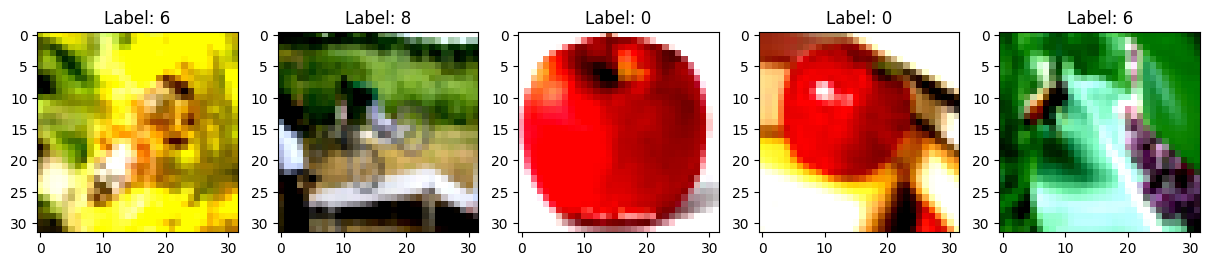

In [ ]:
import random
import matplotlib.pyplot as plt

# Obtener una muestra aleatoria de imágenes de las primeras 20 clases del conjunto de datos de prueba
images, labels = next(iter(test_loader))

selected_classes = list(range(20))
selected_indices = [i for i in range(len(labels)) if labels[i] in selected_classes]

random_indices = random.sample(selected_indices, 5)
sample_images = [images[i] for i in random_indices]
sample_labels = [labels[i] for i in random_indices]

# Visualizar las imágenes
fig, axs = plt.subplots(1, 5, figsize=(15, 3))
for i in range(5):
    axs[i].imshow((sample_images[i].numpy().transpose((1, 2, 0)) + 0.5).clip(0, 1))
    axs[i].set_title(f"Label: {sample_labels[i]}")
plt.show()


In [ ]:
import torch.nn as nn

class AlexNet(nn.Module):
    def __init__(self, num_classes=100):
        super(AlexNet, self).__init__()
        # Definición de la capa features, que contiene las capas convolucionales
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        # Definición de la capa avgpool, que realiza un promedio adaptativo sobre la salida de las capas convolucionales
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        # Definición de la capa classifier, que contiene las capas lineales
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes),
        )
        # Método forward, que define cómo se procesan los datos a través de la red
    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        x = self.classifier(x)
        return x


Using device: cuda
Epoch [1/100], Train Loss: 4.1034, Train Acc: 0.0962, Test Loss: 3.3260, Test Acc: 0.1000, Time: 10.68s
Epoch [2/100], Train Loss: 2.5518, Train Acc: 0.1004, Test Loss: 2.3654, Test Acc: 0.1000, Time: 4.71s
Epoch [3/100], Train Loss: 2.3419, Train Acc: 0.1002, Test Loss: 2.3215, Test Acc: 0.1000, Time: 4.76s
Epoch [4/100], Train Loss: 2.3269, Train Acc: 0.1058, Test Loss: 2.3286, Test Acc: 0.1240, Time: 4.48s
Epoch [5/100], Train Loss: 2.2989, Train Acc: 0.1278, Test Loss: 2.2055, Test Acc: 0.1850, Time: 5.00s
Epoch [6/100], Train Loss: 2.2129, Train Acc: 0.1718, Test Loss: 2.1882, Test Acc: 0.1710, Time: 4.46s
Epoch [7/100], Train Loss: 2.1501, Train Acc: 0.1814, Test Loss: 2.0567, Test Acc: 0.2060, Time: 4.46s
Epoch [8/100], Train Loss: 2.0518, Train Acc: 0.2132, Test Loss: 1.9799, Test Acc: 0.2770, Time: 4.98s
Epoch [9/100], Train Loss: 2.0551, Train Acc: 0.2242, Test Loss: 2.1384, Test Acc: 0.2040, Time: 4.52s
Epoch [10/100], Train Loss: 2.0004, Train Acc: 0.2416

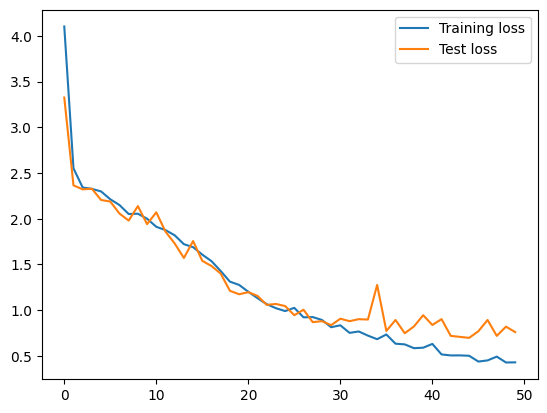

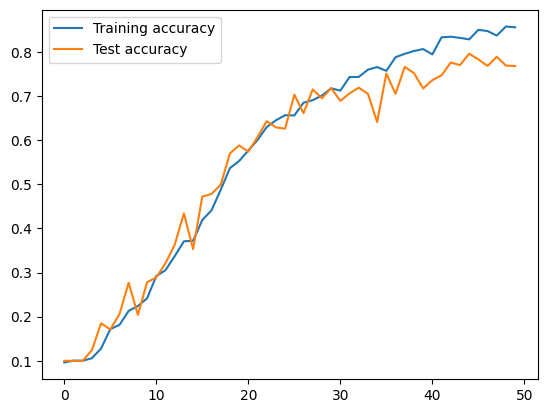

In [ ]:
import torch.optim as optim
import time
import matplotlib.pyplot as plt

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model = AlexNet(num_classes=100).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)

train_losses, test_losses = [], []
train_accs, test_accs = [], []

num_epochs = 100
early_stop_counter = 0
early_stop_patience = 5
best_test_acc = 0

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss, train_acc = 0, 0
    model.train()
    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        _, predictions = torch.max(outputs, 1)
        train_acc += torch.sum(predictions == targets.data)
    train_loss = train_loss / len(train_loader.dataset)
    train_acc = train_acc.float() / len(train_loader.dataset)
    train_losses.append(train_loss)
    train_accs.append(train_acc)

    test_loss, test_acc = 0, 0
    model.eval()
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss += loss.item() * inputs.size(0)
            _, predictions = torch.max(outputs, 1)
            test_acc += torch.sum(predictions == targets.data)
        test_loss = test_loss / len(test_loader.dataset)
        test_acc = test_acc.float() / len(test_loader.dataset)
        test_losses.append(test_loss)
        test_accs.append(test_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, '
          f'Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}, Time: {time.time() - start_time:.2f}s')
    
    # Early stopping (técnica de mejora para detener el entrenamiento en un punto óptimo)
    if test_acc > best_test_acc:
        best_test_acc = test_acc
        early_stop_counter = 0
    else:
        early_stop_counter += 1
    if early_stop_counter == early_stop_patience:
        print('Early stopping')
        break

print('Training finished')

# graficar los valores de pérdida
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Test loss')
plt.legend()
plt.show()

#Conversión de valores de precisión GPU a arreglo NumPy
train_accs = [t.cpu().numpy() for t in train_accs]
test_accs = [t.cpu().numpy() for t in test_accs]

# graficar los valores de precisión
plt.plot(train_accs, label='Training accuracy')
plt.plot(test_accs, label='Test accuracy')
plt.legend()
plt.show()



In [ ]:
torch.save(model.state_dict(), 'model.pth')

In [ ]:
import torch.nn as nn
from PIL import Image
import torchvision.transforms as transforms


device = torch.device('cpu')

# Montar Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Definir el modelo y los pesos
model = AlexNet(num_classes=100).to(device)
model.load_state_dict(torch.load('/content/drive/MyDrive/INTELIGENCIA ARTIFICIAL/LAB 2/AlexNet/model.pth', map_location=torch.device('cpu')))

# Cargar una imagen del directorio de collab
img_path = '/content/49-bebe-de-cinco-meses-desarrollo-del-bebe-mes-a-mes.jpg'
img = Image.open(img_path)

# Preprocesar la imagen para que se ajuste al modelo
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])
img = transform(img)
img = img.unsqueeze(0).to(device)

# Correr el modelo y obtener predicciones
model.eval()
with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)
    label = predicted.item()
    #Las etiquetas están definidas para asignarse al númerom obtenido de la predicción (label)
    class_names = [
        'apple', # id 0
        'aquarium_fish',
        'baby',
        'bear',
        'beaver',
        'bed',
        'bee',
        'beetle',
        'bicycle',
        'bottle',
        'bowl',
        'boy',
        'bridge',
        'bus',
        'butterfly',
        'camel',
        'can',
        'castle',
        'caterpillar',
        'cattle',
        'chair',
        'chimpanzee',
        'clock',
        'cloud',
        'cockroach',
        'couch',
        'crab',
        'crocodile',
        'cup',
        'dinosaur',
        'dolphin',
        'elephant',
        'flatfish',
        'forest',
        'fox',
        'girl',
        'hamster',
        'house',
        'kangaroo',
        'computer_keyboard',
        'lamp',
        'lawn_mower',
        'leopard',
        'lion',
        'lizard',
        'lobster',
        'man',
        'maple_tree',
        'motorcycle',
        'mountain',
        'mouse',
        'mushroom',
        'oak_tree',
        'orange',
        'orchid',
        'otter',
        'palm_tree',
        'pear',
        'pickup_truck',
        'pine_tree',
        'plain',
        'plate',
        'poppy',
        'porcupine',
        'possum',
        'rabbit',
        'raccoon',
        'ray',
        'road',
        'rocket',
        'rose',
        'sea',
        'seal',
        'shark',
        'shrew',
        'skunk',
        'skyscraper',
        'snail',
        'snake',
        'spider',
        'squirrel',
        'streetcar',
        'sunflower',
        'sweet_pepper',
        'table',
        'tank',
        'telephone',
        'television',
        'tiger',
        'tractor',
        'train',
        'trout',
        'tulip',
        'turtle',
        'wardrobe',
        'whale',
        'willow_tree',
        'wolf',
        'woman',
        'worm',
       
    ]
    class_name = class_names[label]
    print(' Clase predicta:', class_name)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
 Clase predicta: baby
